# 房价预测

## 下载数据集

In [21]:
import hashlib
import os
import tarfile
import zipfile
import requests


#@save
#创建一个字典，里面的数据都以一个二元组存储，包含数据集的url和验证文件完整性的sha-1密钥
DATA_HUB = dict()
#所有类似的数据集都托管在地址为DATA_URL的站点上
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#download函数用来下载数据集
#将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 
#缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)#每次读取1048576个字节，也就是1M
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


#一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 下载kaggle数据集

In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

#使用pandas读取数据，我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

#训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## 查看数据长什么样

In [23]:
#查看前面4行，查看前4个特征和后两个特征和标签
#数据里面有文本，有特征
#iloc通过索引的具体值来取数据
#最后一个数据就是标签，房价
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [24]:
#我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 
#因此，在将数据提供给模型之前，我们将其从数据集中删除。
#pd.concat是将训练集和测试集拼接在一起
#train_data.iloc[:,1:-1]是去掉训练集的ID和label，选择1：-1之间的数据，也就是不包括ID和label
#test_data.iloc[:,1:]是去掉测试集的ID
#这里需要两个括号，少一个括号就会报错
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

In [25]:
#将所有缺失值替换为相应特征的平均值。
#所有非文本的数值作归一化
#找到非文本数据的所有下标
numeric_features=all_features.dtypes[all_features.dtypes !='object'].index
#所有非文本的数值作归一化
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/x.std())
#将所有缺失值替换为相应特征的平均值。
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [26]:
#文本数据做one-hot编码
## “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [27]:
#从pandas格式中通过values属性提取NumPy格式，并将其转换为张量表示用于训练。
#因为tensor是专门为GPU加速设计的矩阵，而numpy却不行。其实就相当于一个为GPU设计的数据结构。
#numpy是64位的
#all_features[:n_train].values第一维的数据提取为一个numpy数组
n_train=train_data.shape[0] #1460
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
train_labels.shape,train_features.shape,test_features.shape

(torch.Size([1460, 1]), torch.Size([1460, 331]), torch.Size([1459, 331]))

## 训练

In [87]:
loss=nn.MSELoss()
in_features=train_features.shape[1]

def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

## 损失函数采用均方根误差

#如果采用均方误差，那房价比较高的有可能差值比较大，我们更关系相对误差(y-y^)/y，因为涉及到除法，我们取对数
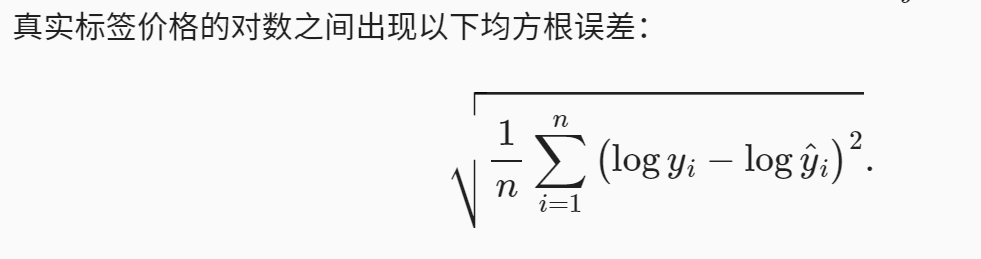

In [88]:
def log_rmse(net,features,labels):
    #torch.clamp()是将输入限制在一个区间范围内
     # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [89]:
#训练函数借助Adam优化器，对学习率没有那么敏感
def train(net, train_features, train_labels, test_features, test_labels,num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [90]:
#在K折交叉验证过程中返回第i折的数据。 返回了训练集和验证集，x和y分别代表数据和标签。
#具体地说，它选择第个切片作为验证数据，其余部分作为训练数据。
def get_k_fold_data(k, i, X, y):
    assert k > 1
    #每一折的大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        #一折的下标
        idx = slice(j * fold_size, (j + 1) * fold_size)
        #数据和标签，标签只有1个特征
        X_part, y_part = X[idx, :], y[idx]
        #是当前折，就作为验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None: #train是空的话，说明还没有第一次看到他
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [91]:
#返回训练和验证的平均值
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train, y_train)
        net=get_net()
        train_ls, valid_ls=train(net,*data,num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum+=train_ls[-1]
        #print(train_ls[-1])
        valid_l_sum+=valid_ls[-1]
        #print(valid_ls[-1])
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, ' f'valid log rmse {float(valid_ls[-1]):f}')
    
    return train_l_sum/k,valid_l_sum/k 

fold 1, train log rmse 0.169543, valid log rmse 0.156092
fold 2, train log rmse 0.162170, valid log rmse 0.189854
fold 3, train log rmse 0.163845, valid log rmse 0.169033
fold 4, train log rmse 0.168467, valid log rmse 0.154601
fold 5, train log rmse 0.162796, valid log rmse 0.182861
5-折验证: 平均训练log rmse: 0.165364 ,平均验证log rmse: 0.170488


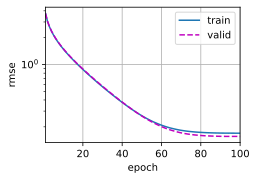

In [92]:
#平均验证的log rmse是我们care的东西
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f} ,'f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.162279


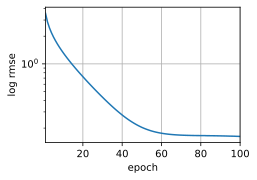

In [93]:
#提交kaggle预测
def train_and_pred(train_features, test_feature, train_labels, test_data,num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    #pd.Series一维数组
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size)

# 答疑

+ 随机抽取少量数据调做K折交叉验证，调出来一个大概好的范围，然后再全部数据集上再调两三次